In [1]:
import optuna
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

env_name = 'CartPole-v1'
search_env = Monitor(gym.make(env_name))

# Função de avaliação
def evaluate(trial):
    model_params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'n_steps': 2048,
        'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        'n_epochs': trial.suggest_categorical('n_epochs', [5, 10, 20]),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'gae_lambda': trial.suggest_float('gae_lambda', 0.8, 0.99),
        'clip_range': trial.suggest_float('clip_range', 0.1, 0.4),
        'normalize_advantage': trial.suggest_categorical('normalize_advantage', [True, False]),
        'ent_coef': trial.suggest_float('ent_coef', 0.0, 0.1),
        'vf_coef': trial.suggest_float('vf_coef', 0.1, 0.9),
        'max_grad_norm': trial.suggest_float('max_grad_norm', 0.1, 1),
        'target_kl': trial.suggest_float('target_kl', 0.01, 0.5)
    }
    
    # Criação do modelo PPO
    model = PPO('MlpPolicy', search_env, verbose=0, **model_params)
    
    # Treinamento do modelo
    model.learn(total_timesteps=200)  # Ajuste o número de etapas conforme necessário

    # Avaliação do modelo
    mean_reward, _ = evaluate_policy(model, search_env, n_eval_episodes=1000)

    return mean_reward

# Número de updates
# Target Kullback-leibner
# entropy coefficient


class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value is not None and trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()


In [2]:
import numpy as np

# Define o estudo Optuna
study = optuna.create_study(direction='maximize')
study.optimize(evaluate, n_trials=50, callbacks=[CheckHyperparamMeanRewardThreshold(500.0)], show_progress_bar=True)

[I 2024-02-19 10:12:27,153] A new study created in memory with name: no-name-7a0caa2d-f60a-4624-b808-8d0f39a7300e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-19 10:12:59,980] Trial 0 finished with value: 76.761 and parameters: {'learning_rate': 7.305127382393887e-05, 'batch_size': 32, 'n_epochs': 5, 'gamma': 0.9567058984246454, 'gae_lambda': 0.8835092435937141, 'clip_range': 0.15970178968859566, 'normalize_advantage': True, 'ent_coef': 0.0020114405990166342, 'vf_coef': 0.7448589764953555, 'max_grad_norm': 4.6583906284181245, 'target_kl': 0.03429980940282858}. Best is trial 0 with value: 76.761.
[I 2024-02-19 10:13:38,398] Trial 1 finished with value: 74.288 and parameters: {'learning_rate': 8.661834125688456e-05, 'batch_size': 16, 'n_epochs': 20, 'gamma': 0.9426336478905718, 'gae_lambda': 0.8868509199026539, 'clip_range': 0.11385388019345759, 'normalize_advantage': False, 'ent_coef': 0.06930311048313152, 'vf_coef': 0.35165778435000017, 'max_grad_norm': 3.788609340997256, 'target_kl': 0.41685921793638453}. Best is trial 0 with value: 76.761.
[I 2024-02-19 10:13:54,383] Trial 2 finished with value: 34.449 and parameters: {'learning

In [3]:
# Obtém os melhores hiperparâmetros
best_model_params = {**study.best_params}

train_env = Monitor(gym.make(env_name))
# Criação do modelo com os melhores hiperparâmetros
best_model = PPO('MlpPolicy', train_env, **best_model_params)

# Treinamento do modelo final
best_model.learn(total_timesteps=int(1e6), log_interval=1, progress_bar=True)  # Ajuste o número de etapas conforme necessário

eval_env = Monitor(gym.make(env_name))
evaluate_policy(best_model, eval_env, n_eval_episodes=1000, return_episode_rewards = False)


Output()

(496.068, 23.23220557760283)

In [8]:
import gymnasium

from stable_baselines3.ppo import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes

env = Monitor(gymnasium.make("CartPole-v1"))

args = {
    'policy_kwargs': dict(net_arch=[256, 256])
    #'learning_starts': 100
    #'buffer_size': 10_000,
    #'learning_rate': 0.01,
    #'target_update_interval': 1000
}
model = PPO("MlpPolicy", env, verbose=0, **args)
seeds = [1, 2, 3, 5, 8]


for seed in seeds:
    import random
    random.seed(seed)

    import numpy as np
    np.random.seed(seed)

    #env.seed(seed)
    env.action_space.seed(seed)

    import torch
    torch.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #model.set_random_seed(seed)
    model.learn(total_timesteps=int(2e4))

model.set_random_seed(0)
eval_env = Monitor(gymnasium.make('CartPole-v1'))
_, _ = evaluate_policy(model, eval_env, n_eval_episodes=int(1e3), return_episode_rewards = False)

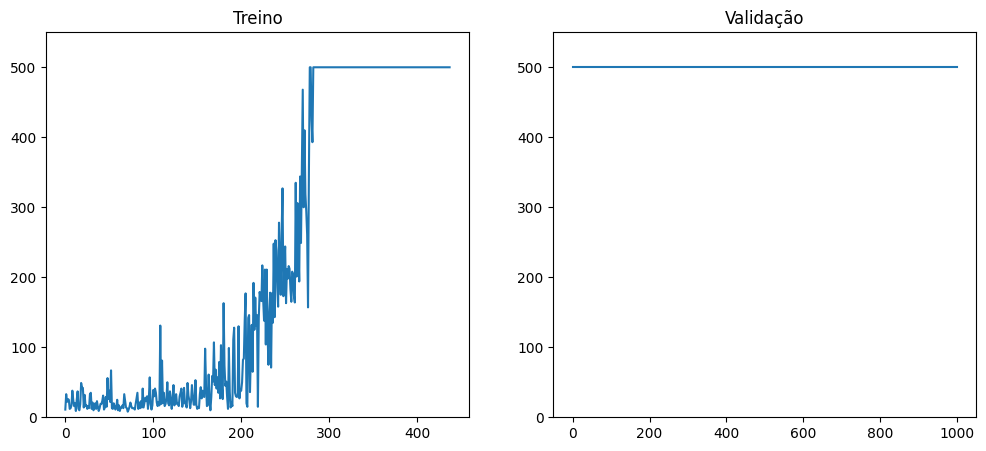

In [9]:
import matplotlib.pyplot as plt
import numpy as np

train_rewards = np.array(env.get_episode_rewards())
eval_rewards = np.array(eval_env.get_episode_rewards())

figs, axs = plt.subplots(1,2, figsize=(12, 5))
axs[0].plot(train_rewards)
axs[0].set_ylim(0, 550)
axs[0].set_title('Treino')

axs[1].plot(eval_rewards)
axs[1].set_ylim(0, 550)
axs[1].set_title('Validação')

plt.show()

In [5]:
model.save('ppo_funcional')

In [7]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# Parallel environments
vec_env = make_vec_env("CartPole-v1", n_envs=4)

model = PPO("MlpPolicy", vec_env, verbose=0)
model.learn(total_timesteps=250000)

eval_env = Monitor(gym.make("CartPole-v1"))
evaluate_policy(model, eval_env, n_eval_episodes=1000, return_episode_rewards = False)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    fps             | 5870     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.4        |
|    ep_rew_mean          | 41.4        |
| time/                   |             |
|    fps                  | 2346        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.015227657 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | -0.0102     |
|    learning

(500.0, 0.0)

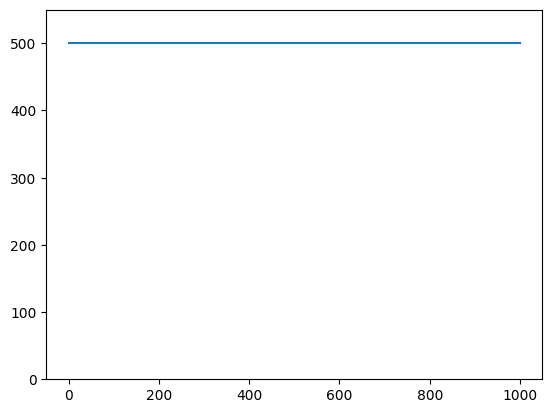

In [9]:
import numpy as np
import matplotlib.pyplot as plt
rewards = np.array(eval_env.get_episode_rewards())
plt.plot(rewards)
plt.ylim(0, 550)
plt.show()